In [38]:
import os
import faiss
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
import pinecone
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
image_data = load_dataset("conceptual_captions", split="train")
     

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/Users/sebastianwiesner/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


In [4]:
image_data_df = pd.DataFrame(image_data[:100])

In [5]:
image_data_df.head()

,image_url,caption
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .


In [6]:
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

In [7]:
def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

In [8]:
def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [9]:
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [10]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

,image_url,caption,is_valid
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True


In [11]:
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

/Users/sebastianwiesner/Documents/GitHub/pinecone/.venv/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


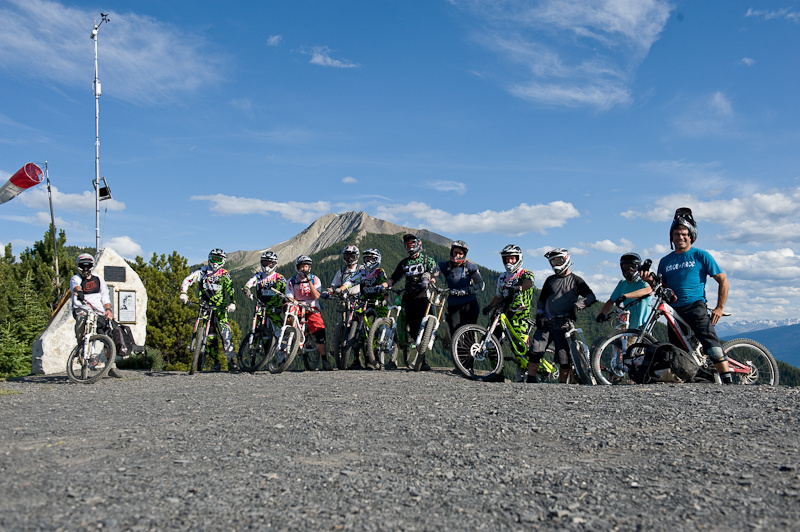

In [14]:
image_data_df.iloc[14]["image"]

In [15]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

In [17]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt")

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array 
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [18]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [19]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [20]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922298, -0.08825964, 0.020317197, -0.127..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.004146844, 0.18943518, -0.12396961, 0.3029..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28738007, -0.3481406, -0.042885076, 0.401..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.5606451, -0.15138105, -0.43740284, -0.3392..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035291567, 0.24262652, -0.12724844, -0.210..."


In [21]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image, 
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

In [22]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [23]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [24]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings,img_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922298, -0.08825964, 0.020317197, -0.127...","[[-0.003400065, -0.05358524, 0.35247576, 0.331..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.004146844, 0.18943518, -0.12396961, 0.3029...","[[-0.25020325, -0.13257739, 0.09706184, 0.9788..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28738007, -0.3481406, -0.042885076, 0.401...","[[-0.39855862, 0.29502586, -0.119867, 0.334940..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.5606451, -0.15138105, -0.43740284, -0.3392...","[[-0.16011223, -0.2958299, -0.11380547, -0.048..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035291567, 0.24262652, -0.12724844, -0.210...","[[0.18214476, 0.050187632, -0.64188623, -0.079..."


In [25]:
def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

In [26]:
def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  list_captions = [top_images.iloc[idx].caption for idx in index_values] 
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

In [27]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else: 
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]
    
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    
    """
    Sort Cosine Similarity Column in Descending Order 
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]
    
    return most_similar_articles[revevant_cols].reset_index()

In [28]:
image_data_df.columns

Index(['image_url', 'caption', 'is_valid', 'image', 'text_embeddings',
       'img_embeddings'],
      dtype='object')

In [34]:
query_caption = image_data_df.iloc[10].caption
top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: actor arrives for the premiere of the film


,index,caption,image,cos_sim
0,53,actor and daughters uk premiere held,<PIL.Image.Image image mode=RGB size=640x468 a...,0.272514
1,41,pop artist attends the 3rd annual at guest house,<PIL.Image.Image image mode=RGB size=490x612 a...,0.268562
2,16,actor attends the premiere of season,<PIL.Image.Image image mode=RGB size=499x612 a...,0.247936
3,30,actor arrives to the premiere,<PIL.Image.Image image mode=RGB size=444x612 a...,0.247662


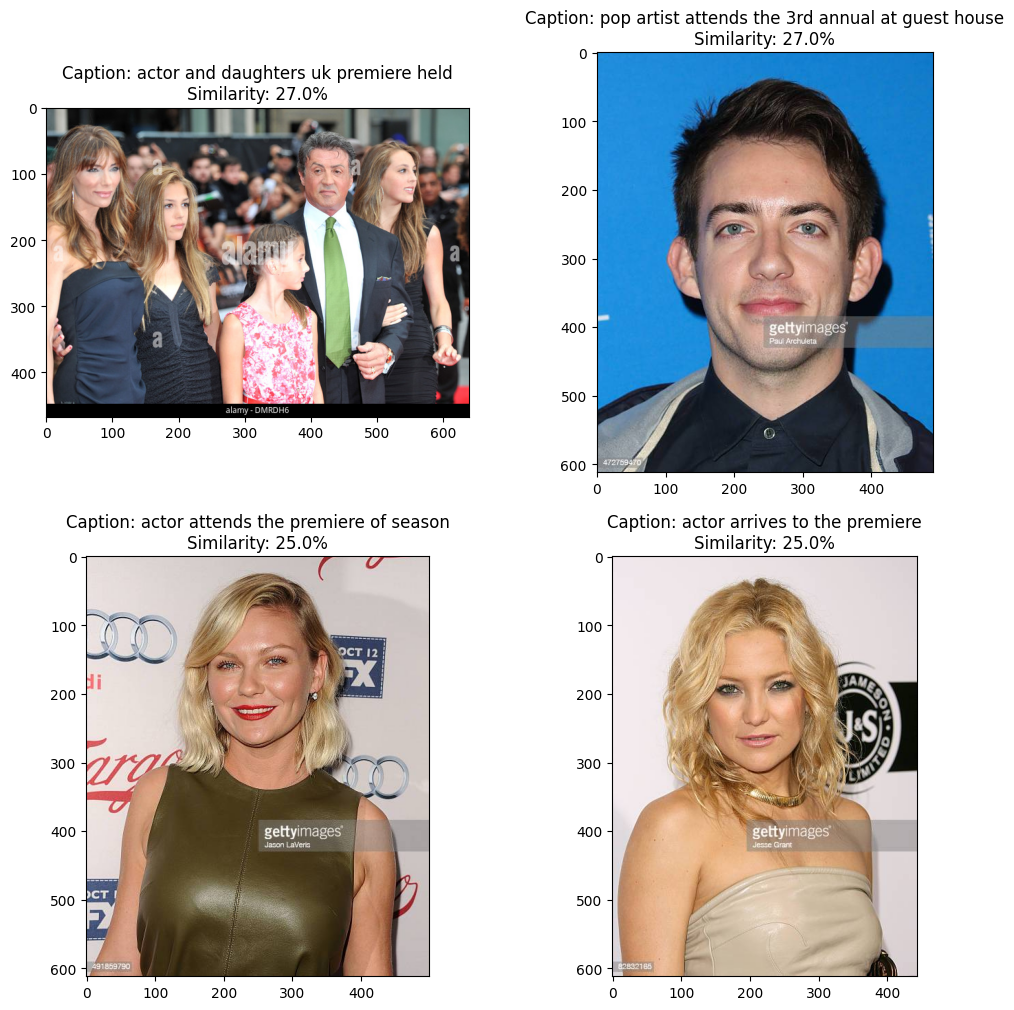

In [35]:
plot_images_by_side(top_images)

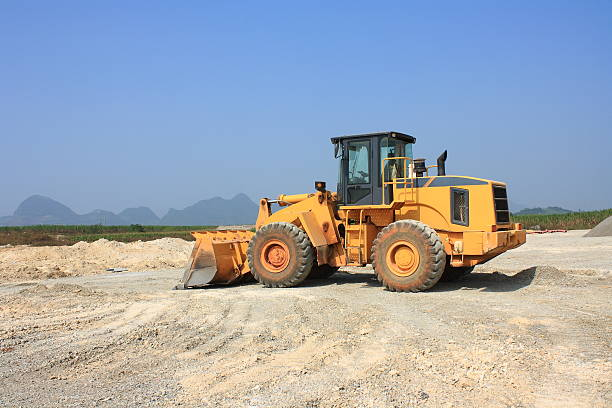

In [36]:

query_image = image_data_df.iloc[55].image
query_image

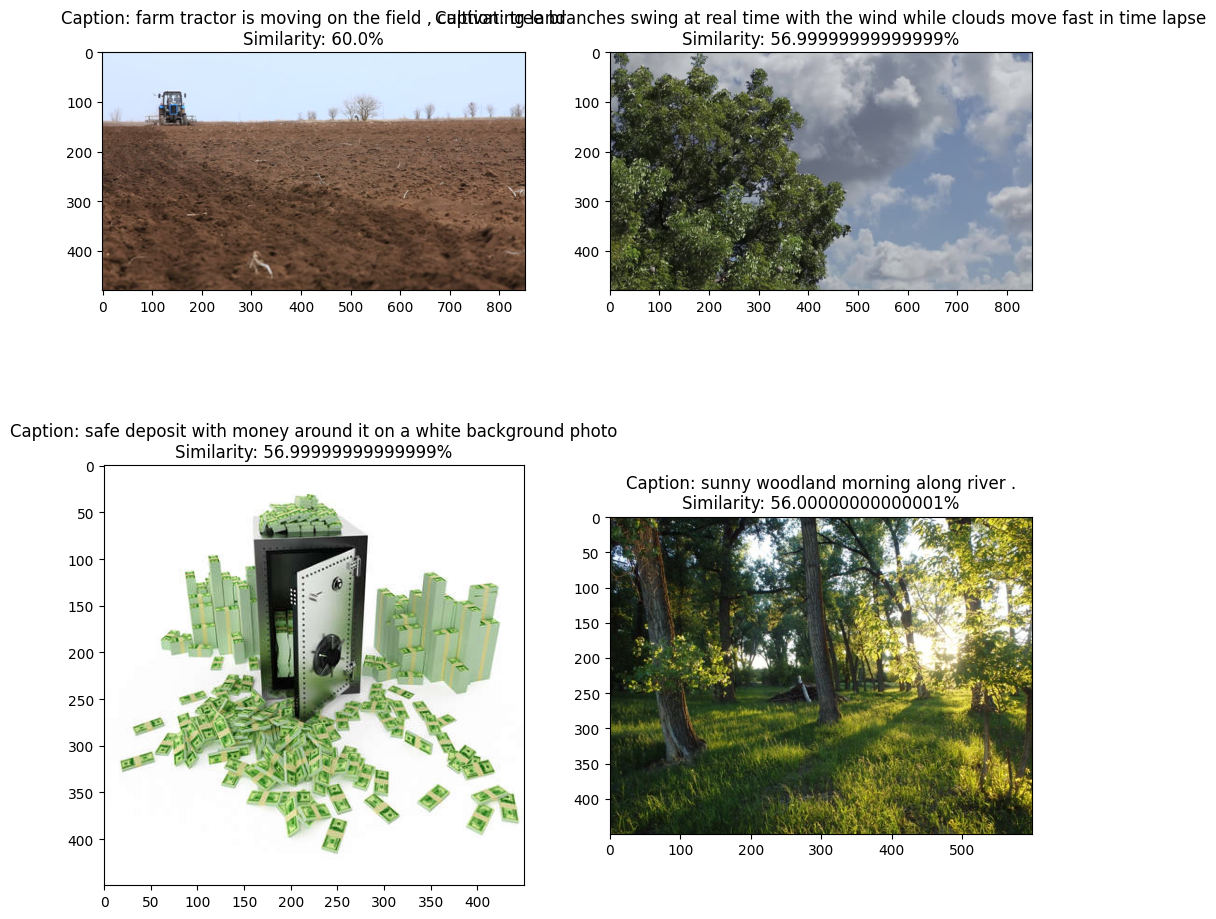

In [37]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

In [ ]:
pinecone.init(
    api_key = "86378080-7c27-464a-acbb-9e83d7455bcb", 
    environment="northamerica-northeast1-gcp"
)

my_index_name = "clip-image-search"
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name, 
                        dimension=vector_dim, 
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# Connect to the index
my_index = pinecone.Index(index_name = my_index_name)

In [39]:
my_index.describe_index_stats()
#https://github.com/keitazoumana/CLIP_Use_Case_Pinecone/blob/main/CLIP_Text_to_Image_Search.ipynb
#https://www.pinecone.io/learn/clip-image-search/

NameError: name 'my_index' is not defined